# Imports and model loading

In [3]:
import pathlib
import pickle
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from src.data_loaders import Importer
from src.training_utils import train_model
from src.cam_utils import generate_CAMs, CAMs_plot_gen_final, viz_final
from src.utils import test_model, get_preds_from_model
from src.architecture import CNN_SSH

%reload_ext autoreload
%autoreload 2
%aimport src.training_utils
%aimport src.cam_utils
%aimport src.utils

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
plots_save_path = pathlib.Path("./00_demonstrations_data/figures/")
png_save_path = plots_save_path.joinpath("PNG/")
models_root = pathlib.Path("./00_demonstrations_data/models/")


plots_save_path.mkdir(exist_ok=True, parents=True)
png_save_path.mkdir(exist_ok=True, parents=True)
models_root.mkdir(exist_ok=True, parents=True)

Here we load the model for the CAM analysis. The options are:
* 1. The model we trained in [the previous notebook](./02_architecture_training.ipynb) notebook, or one of the models highlighted in the paper:
* 2. [well_generalizing_good_CAM](./00_demonstrations_data/models/well_generalizing_good_CAM/)
* 3. [well_generalizing_misleading_CAM](./00_demonstrations_data/models/well_generalizing_misleading_CAM/)
* 4. [poorly_generalizing_good_CAM](./00_demonstrations_data/models/poorly_generalizing_good_CAM/)
* 5. [poorly_generalizing_misleading_CAM](./00_demonstrations_data/models/poorly_generalizing_misleading_CAM/)

In [3]:
available_models = {
    1: models_root.joinpath('training_demonstration'),
    2: models_root.joinpath('well_generalizing_good_CAM'),
    3: models_root.joinpath('well_generalizing_misleading_CAM'),
    4: models_root.joinpath('poorly_generalizing_good_CAM'),
    5: models_root.joinpath('poorly_generalizing_misleading_CAM'),
}

In [4]:
model_to_load = available_models[1]

In [5]:
load_path = pathlib.Path("./00_demonstrations_data/datasets")

disorderless_ds_path = load_path.joinpath("disorderless")
disordered_001_ds_path = load_path.joinpath("disordered_W=0.01")
disordered_005_ds_path = load_path.joinpath("disordered_W=0.05")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else
                        'mps' if torch.backends.mps.is_available() else
                        "cpu")

In [7]:
num_classes = 2
class_names = ["Trivial", "Topological"]

In [8]:
model = CNN_SSH().float().to(device)
model.load_state_dict(torch.load(model_to_load.joinpath("trained_model.dict"), map_location=device))

<All keys matched successfully>

# Class Activation Mapping

Generation of CAMs. The helper functions are defined in [cam_utils.py](./src/cam_utils.py) helper file.

You can also toggle between CAM and grad-CAM

In [ ]:
grad_cam = False

In [9]:
test_ds = Importer(disorderless_ds_path, -1)
test_loader = test_ds.get_test_loader()

cams_folder = model_to_load.joinpath("CAM")
cams_folder.mkdir(parents=True, exist_ok=True)

model_name = model_to_load.joinpath("trained_model")
cams_arr, preds = generate_CAMs(model, test_loader, class_names, device, test_ds, grad_cam)
cams_arr = np.array(cams_arr).squeeze()
cams_arr_np = np.zeros(shape=(cams_arr.shape[0], 2, 50, 50))
for r_no, (el1, el2) in enumerate(cams_arr):
    cams_arr_np[r_no] = np.array([np.array(el1), np.array(el2)])
del el1, el2
del cams_arr
viz_tuple = (cams_arr_np, preds)
with open(cams_folder.joinpath(f"viz_tuple.pkl"), "wb") as f:
    pickle.dump(viz_tuple, f)
del f

CAM generation:   0%|          | 0/500 [00:00<?, ?sample/s]

Generate CAM for a single data sample

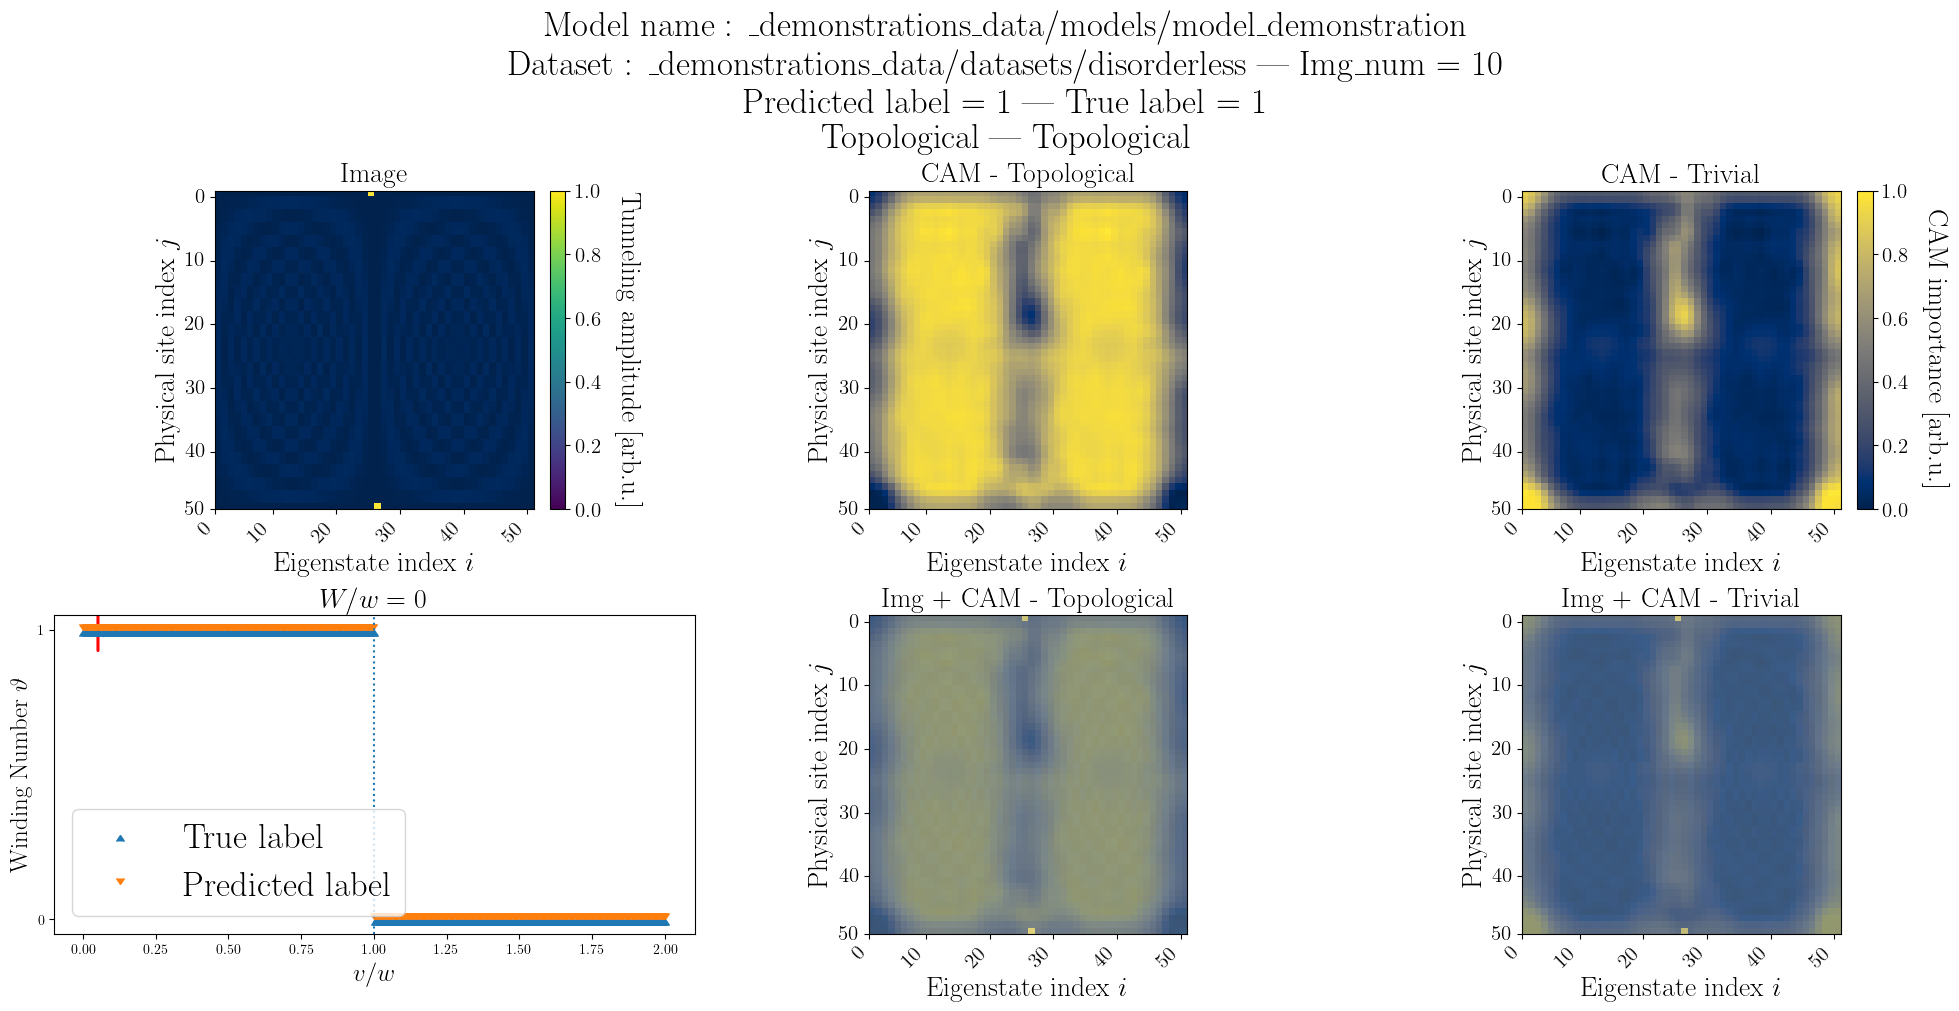

In [10]:
cam_ind = 10

viz_final(cams_arr_np, preds, cam_ind, model_to_load, test_ds, disorderless_ds_path, test_loader)

Generate CAMs for the whole dataset   

In [ ]:
cam_pbar = tqdm(total=test_loader.dataset.Y.shape[0], desc="CAM Plotting", position=1, leave=False, unit="sample", colour="blue")
for img_ind in range(test_loader.dataset.Y.shape[0]):
    viz_final(cams_arr_np, preds, img_ind, model_to_load, test_ds, test_loader, save=cams_folder.joinpath(f"ind={img_ind}_v={((img_ind+1)/100):.2f}.png"))
    cam_pbar.update(1)
cam_pbar.close()

## Recreation of Fig. 2

To generate all CAMs for the models highlighted in Fig.2 please run file [04a_figure_models_analysis.py](./04a_figure_models_analysis.py), or download them from Zenodo.  
In order to fully recreate the figure you also need to download from Zenodo the target and predicted phase diagrams, and CAM data for the toy model.


In [1]:
from src.cam_utils import recreate_fig_2

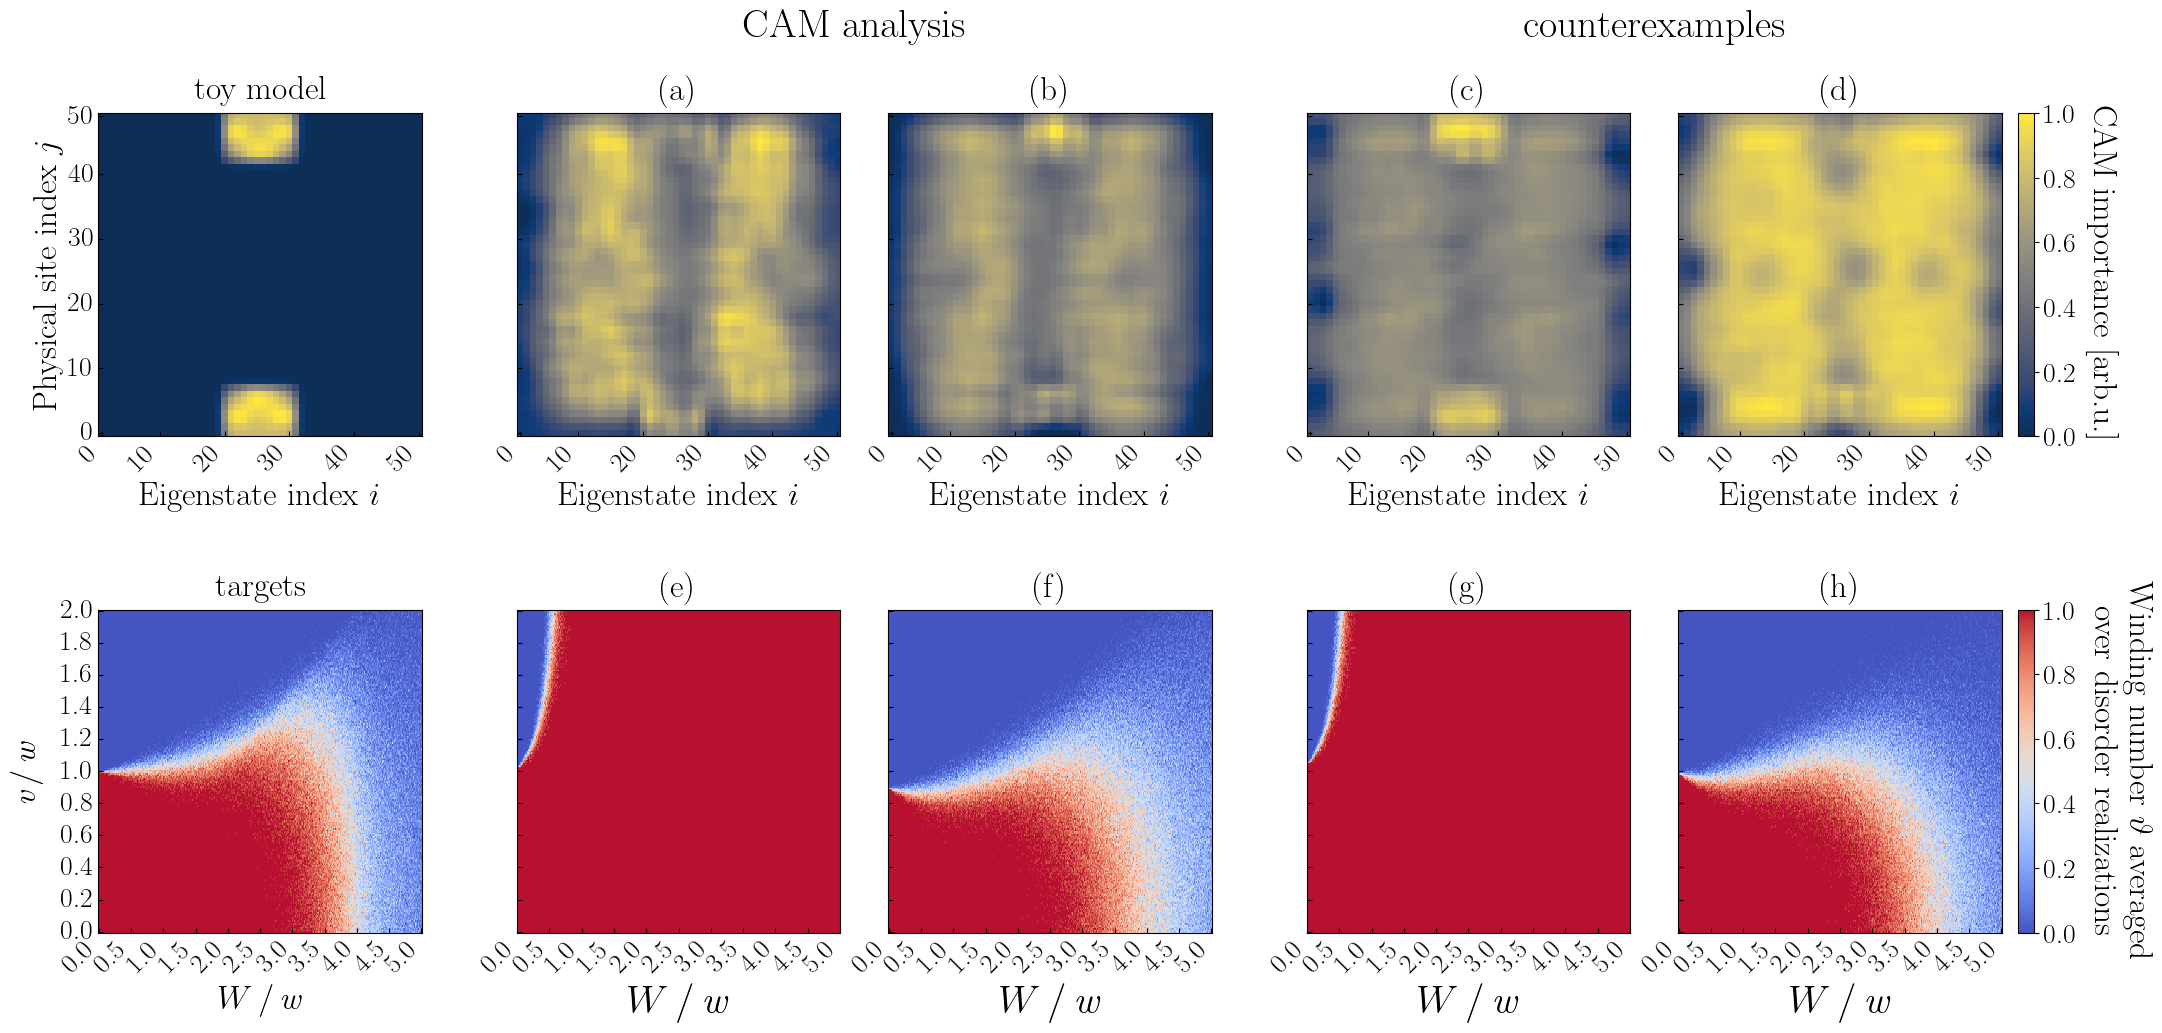

In [6]:
recreate_fig_2(models_root, plots_save_path)